Памперсы или пиво? Практический проект по созданию рекомендательной системы.

Цель: Настало время поработать с данными самой большой и самой дорогой компании, занимающейся, похоже, уже всем на свете: от продажи всего и вся, до настройки облачных инфраструктур и создания роботов. Конечно же это компания Джеффа могу-купить-весь-мир Безоса - Amazon.

1.Выберите любой понравившийся вам набор данных по ссылке https://nijianmo.github.io/amazon/index.html, стоит обратить внимание на раздел "Small" subsets for experimentation, где представлены не самые большие датасеты (чтобы и в память поместился, и считался недолго)

2.Проведите базовый EDA - распределения рейтингов, количество уникальных товаров и т.д.

3.Отложите часть данных для тестирования. В рекомендательных системах для этого можно случайным образом “занулить” желаемый процент рейтингов в исходном датасете, чтобы получить “тренировочный набор”, и проверять качество ваших рекомендаций на этих уже не зануленных рейтингах. При этом, если у вас есть временная зависимость в данных, имеет смысл занулять рейтинги “из будущего”, чтобы обучаться на “исторических” покупках/просмотрах и т.д.

4.На основании вашего датасета постройте рекомендательную систему

5.Оцените качество полученных рекомендаций, при помощи подходящих метрик (если вы использовали рейтинги, можно взять RMSE)


In [94]:
!pip install lightfm

  Stored in directory: C:\Users\Valeria\AppData\Local\pip\Cache\wheels\eb\bb\ac\188385a5da6627956be5d9663928483b36da576149ab5b8f79
Successfully built LightFM


In [95]:
from lightfm import LightFM
import pickle
from lightfm.evaluation import precision_at_k, auc_score

D:\programs\Anaconda\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [154]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime

from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

Для анализа амазон предоставляет два файла. В первом содержатся комментарии к товарам, а во втором - оценки к товарам. Название самого товара, к сожалению, вытащить невозможно ни из одного файла. Для того, чтобы идентифицировать товар у нас есть только его ID в виде: **B00005N7P0**.

In [159]:
df_subsc = pd.read_json('Magazine_Subscriptions_5.json', lines = True)

In [160]:
df_subsc

,asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
0,B00005N7P0,NaN,4,"I'm old, and so is my computer. Any advice th...","02 26, 2014",A5QQOOZJOVPSF,John L. Mehlmauer,NaN,Cheapskates guide,1393372800,True,NaN
1,B00005N7PS,NaN,5,"There's nothing to say, but if you want a REAL...","03 6, 2004",A5RHZE7B8SV5Q,gorillazfan249,NaN,The best mature Men's magazine.,1078531200,False,3.0
2,B00005N7PS,NaN,1,If you're the kind of man who looks at himself...,"07 15, 2003",A1RPTVW5VEOSI,Michael J. Edelman,NaN,THE Magazine for the Self-Centered Male,1058227200,False,17.0
3,B00005N7PS,NaN,1,Nothing to it. Just an advertisement. Little...,"01 31, 2015",A1SFRBCMW8XVBW,Hoyett L. Barnett,NaN,Nothing to it. Just an advertisement. Little a...,1422662400,True,NaN
4,B00005N7P0,NaN,5,When PC Magazine ceased publication of their p...,"10 5, 2010",A1IU9VPCBKZPE8,Randolph Eck,NaN,Excellent Computer Magazine,1286236800,True,2.0
5,B00005N7PS,NaN,4,Details is much less indepth / informative as ...,"10 21, 2008",AG6TX1ZJHLMO7,W. Dietrich,NaN,A toned down GQ / Esquire,1224547200,False,2.0
6,B00005N7P0,NaN,5,In my mind BEST PC Magazine for upgrades / har...,"02 25, 2009",A3OIE7IE9LTPJG,GatorMan,NaN,Best PC Magazine,1235520000,True,NaN
7,B00005N7PS,NaN,3,Details is a mildly interesting magazine that ...,"03 15, 2006",A3JPFWKS83R49V,Bryan Carey,NaN,Give Me the Details,1142380800,False,98.0
8,B00005N7P0,NaN,4,Maximum PC is a magazine for electronics freak...,"09 24, 2007",A3JPFWKS83R49V,Bryan Carey,NaN,Maximizing Electronics Enjoyment,1190592000,False,2.0
9,B00005N7P0,NaN,1,Maximum PC's slogan is Maximum PC. Minimum BS....,"03 9, 2004",A5RHZE7B8SV5Q,gorillazfan249,NaN,More like half and half PC and BS.,1078790400,False,5.0


In [79]:
df = pd.read_csv('Magazine_Subscriptions.csv', header = None, names = ['UserId', 'ItemId', 'Rating', 'timestamp'])
#movies = pd.read_csv(movies_data)
#ratings = pd.read_csv(ratings_data)

In [80]:
df.head()

,UserId,ItemId,Rating,timestamp
0,B00005N7P0,AH2IFH762VY5U,5.0,1005177600
1,B00005N7P0,AOSFI0JEYU4XM,5.0,1004486400
2,B00005N7OJ,A3JPFWKS83R49V,3.0,1174694400
3,B00005N7OJ,A19FKU6JZQ2ECJ,5.0,1163116800
4,B00005N7P0,A25MDGOMZ2GALN,5.0,1405296000


Последняя колонка скорее всего является timestamp в неверном формате.

In [81]:
df.shape

(89689, 4)

In [82]:
# Уникальных товаров
df.ItemId.nunique()

72098

In [83]:
# Уникальных пользователей
df.UserId.nunique()

2428

In [147]:
# Поменяем формат timestamp
import datetime
df['timestamp_1'] = datetime.datetime(2012, 3, 16, 1, 0)
k = 0
for i in range(df.shape[0]):
    df['timestamp_1'][i] = datetime.datetime.fromtimestamp(df['timestamp'][i])
    k += 1
    if k%10000 == 0:
        print(k)

D:\programs\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000


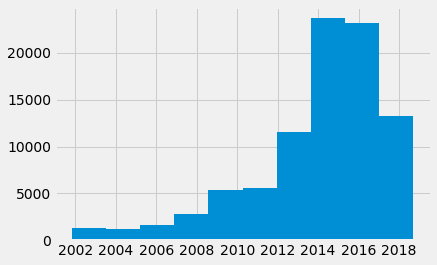

In [149]:
df.timestamp_1.hist()

In [85]:
df.head()

,UserId,ItemId,Rating,timestamp,timestamp_1
0,B00005N7P0,AH2IFH762VY5U,5.0,1005177600,2001-11-08 03:00:00
1,B00005N7P0,AOSFI0JEYU4XM,5.0,1004486400,2001-10-31 03:00:00
2,B00005N7OJ,A3JPFWKS83R49V,3.0,1174694400,2007-03-24 03:00:00
3,B00005N7OJ,A19FKU6JZQ2ECJ,5.0,1163116800,2006-11-10 03:00:00
4,B00005N7P0,A25MDGOMZ2GALN,5.0,1405296000,2014-07-14 03:00:00


Text(0, 0.5, 'Frequency')

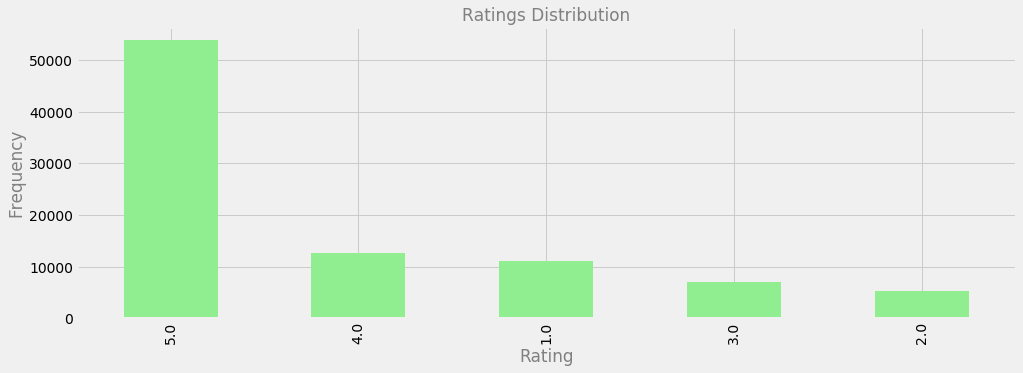

In [87]:
plt.figure(figsize=(15,5))
plt.style.use('fivethirtyeight')
df['Rating'].value_counts().plot.bar(color = 'lightgreen')
plt.title("Ratings Distribution", color = 'grey', fontsize = 17)
plt.xlabel("Rating", color = 'grey')
plt.ylabel("Frequency", color = 'grey')

In [88]:
def create_interaction_matrix(df, user_col, item_col, rating_col, norm=False, threshold=None):   
    interactions = df.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [89]:
interactions = create_interaction_matrix(df = df,
                                         user_col = 'UserId',
                                         item_col = 'ItemId',
                                         rating_col = 'Rating',
                                         norm=True,
                                         threshold = 3)
interactions.shape

(2428, 72098)

In [116]:
interactions.head()

ItemId,A0068533X8Y5TYUJWWIC,A02292976AOUT3I4ZLFA,A0328927TA7ECTIKNP3G,A0333047WGK24IZKLDP2,A0479411TZTHITJ9TFB8,A0534350D18UHJKPKZ1W,A0540974HOUD6MJ5Z0P7,A0743345UFTOA4V1Z7W,A07456856U64LDNYL2U6,A095896256EBDK3E42GW,...,AZZGVG93Z4LM2,AZZHOEL2MLCZ0,AZZM0EGX7OIJH,AZZP6XXCKUBK1,AZZQFUNTBFBUD,AZZS7W015QH2L,AZZVFTH1QONVD,AZZXJAE2DILET,AZZXKCCW8GG21,AZZXZMUSB0GBL
UserId,,,,,,,,,,,,,,,,,,,,,
B00005N7NQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00005N7O3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00005N7O4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00005N7O6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00005N7O9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
def create_user_dict(interactions):
    result = {}
    ids = 0
    
    for i in interactions.index:
        if i not in result:
            result[i] = ids
            ids += 1
    
    return result

In [130]:
user_dict = create_user_dict(interactions=interactions)

user_dict

{'B00005N7NQ': 0,
 'B00005N7O3': 1,
 'B00005N7O4': 2,
 'B00005N7O6': 3,
 'B00005N7O9': 4,
 'B00005N7OA': 5,
 'B00005N7OC': 6,
 'B00005N7OD': 7,
 'B00005N7OF': 8,
 'B00005N7OJ': 9,
 'B00005N7OP': 10,
 'B00005N7OU': 11,
 'B00005N7OV': 12,
 'B00005N7P0': 13,
 'B00005N7P8': 14,
 'B00005N7PA': 15,
 'B00005N7PG': 16,
 'B00005N7PH': 17,
 'B00005N7PI': 18,
 'B00005N7PL': 19,
 'B00005N7PN': 20,
 'B00005N7PR': 21,
 'B00005N7PS': 22,
 'B00005N7PT': 23,
 'B00005N7Q1': 24,
 'B00005N7Q2': 25,
 'B00005N7Q5': 26,
 'B00005N7QA': 27,
 'B00005N7QC': 28,
 'B00005N7QD': 29,
 'B00005N7QE': 30,
 'B00005N7QG': 31,
 'B00005N7QH': 32,
 'B00005N7QI': 33,
 'B00005N7QJ': 34,
 'B00005N7QL': 35,
 'B00005N7QN': 36,
 'B00005N7QO': 37,
 'B00005N7QS': 38,
 'B00005N7QW': 39,
 'B00005N7QY': 40,
 'B00005N7R0': 41,
 'B00005N7R2': 42,
 'B00005N7R5': 43,
 'B00005N7R6': 44,
 'B00005N7R7': 45,
 'B00005N7RA': 46,
 'B00005N7RD': 47,
 'B00005N7RF': 48,
 'B00005N7RJ': 49,
 'B00005N7RO': 50,
 'B00005N7RP': 51,
 'B00005N7RQ': 52,
 'B

In [ ]:
# def create_item_dict(df,id_col,name_col):
#     item_dict = {}
#     for i in range(df.shape[0]):
#         item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
#     return item_dict

# movies_dict = create_item_dict(df = movies,
#                                id_col = 'movieId',
#                                name_col = 'title')

In [93]:
def runMF(interactions, n_components, loss, epoch, n_jobs):
    x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components=n_components, loss=loss)
    model.fit(x, epochs=epoch, num_threads=n_jobs)
    return model

In [96]:
mf_model = runMF(interactions = interactions,
                 n_components = 30,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

In [97]:
?mf_model.predict

In [132]:
def sample_recommendation_user(model, interactions, user_id, user_dict, threshold = 0, nrec_items = 10, show = True):
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x, np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[:nrec_items]
    known_items = list(pd.Series(known_items))
    scores = list(pd.Series(return_score_list))
    if show == True:
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return return_score_list

In [134]:
rec_list = sample_recommendation_user(model = mf_model, 
                                      interactions = interactions, 
                                      user_id = 'B00005N7NQ', 
                                      user_dict = user_dict,
                                      threshold = 0,
                                      nrec_items = 10)

Known Likes:
1- AZUP45Z0PP0FQ
2- AVP1NL6GYMVR
3- AUA7DJCKSWKE9
4- AU627A4UGIW6V
5- ATYV9NMHGBYAO
6- ARPSGH035HXVN
7- ARBDQQV6J9G7C
8- APBYXB3E57M10
9- AP2KE5YLYYCIO
10- AN92S28RV1FQ4
11- AMEBS7Y06RZCL
12- AJNI49ZBUYYEA
13- AJMYX6BWDEHZA
14- AIBAKIY8U292Y
15- AFV2WBIH43W58
16- ADVLRJS633OTD
17- ABD6XEN44YE20
18- AAWQAUO7YRQ1J
19- AAA89DEVXPQYN
20- A82BF05B2NLV5
21- A7EAX85HG3IHZ
22- A70NFM6KHU24F
23- A6G1BFSF0VPIZ
24- A3Q1U14JAG46O5
25- A3Q1KE3S870JKD
26- A3JA4NNFDJ948K
27- A3I5CHF9QZ536X
28- A3GXBWV3KYDNH6
29- A3FSPHSY0NG50G
30- A3FDX7STNUC20I
31- A3F1AQHQLS41IV
32- A3EQQP0LD4Z375
33- A3EODZ1XGHZFNM
34- A3C7N55BDKAZSS
35- A3AY9OT5NG38O0
36- A38AAPXSJN4C5G
37- A3865A28FVFFZO
38- A36Y6O6893JQAT
39- A36I3B0H9M8BV8
40- A36GXBF1EHVT55
41- A359IT81FBX64Y
42- A34PAZQ73SL163
43- A33069Q6O519EX
44- A32GUEPTNZJAL9
45- A2ZTBWX6L2H0QA
46- A2YYNZQNN8AAKN
47- A2YKE87GY2Y7QP
48- A2Y83J199HGCGB
49- A2NPL80C5CJE06
50- A2NMUJ3GHZVI9K
51- A2M0NGAYK1P2WY
52- A2LO2L20NGZWJY
53- A2L2J644RUYSOL
54- A2HIZSF18

In [168]:
import random

In [165]:
customers = list(np.sort(df.UserId.unique())) 
products = list(df.ItemId.unique()) 
ratings = list(df.Rating)

rows = df.UserId.astype('category').cat.codes 
cols = df.ItemId.astype('category').cat.codes 
purchases_sparse = sparse.csr_matrix((ratings, (rows, cols)), shape=(len(customers), len(products)))

In [166]:
def make_train(ratings, pct_test = 0.2):
    test_set = ratings.copy()
    test_set[test_set != 0] = 1
    training_set = ratings.copy() 
    nonzero_inds = training_set.nonzero() 
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) 
    random.seed(0) 
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) 
    samples = random.sample(nonzero_pairs, num_samples) 
    user_inds = [index[0] for index in samples] 
    item_inds = [index[1] for index in samples] 
    training_set[user_inds, item_inds] = 0 
    training_set.eliminate_zeros() 
    return training_set, test_set, list(set(user_inds))  

In [169]:
product_train, product_test, product_users_altered = make_train(purchases_sparse, pct_test = 0.2)

In [170]:
import pickle
from lightfm.evaluation import precision_at_k, auc_score

model = LightFM(loss='warp')
model.fit_partial(product_train, epochs=40, num_threads=2)

with open('saved_model','wb') as f:
            saved_model={'model':model}
            pickle.dump(saved_model, f)


train_auc = auc_score(model, product_train).mean()
test_auc = auc_score(model, product_test).mean()

print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))


AUC: train 1.00, test 0.87.
